In [1]:
import matplotlib.pyplot as plt
import torch

import config
from config import *
from dataLoader import CustomDataset

cuda:0
1.12.0+cu102




In [2]:
# train_dataset = CustomDataset(config.TRAIN_DIR, config.transformations)
# train_data_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
dataset=torchvision.datasets.ImageFolder(config.TRAIN_DIR, transform=config.transformations)
train_data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=config.BATCH_SIZE, shuffle=True)

In [3]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, features_d, num_classes, img_size):
        super(Discriminator, self).__init__()
        self.img_size = img_size

        self.disc = nn.Sequential(
            nn.Conv2d(in_channels + 1, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2 ,1),
            self._block(features_d * 2, features_d * 4, 4, 2 ,1),
            self._block(features_d * 4, features_d * 8, 4, 2 ,1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0)
        )
        self.embed = nn.Embedding(num_classes, img_size * img_size)

    @staticmethod
    def _block(in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).view(labels.shape[0], 1, self.img_size, self.img_size)
        x = torch.cat([x, embedding], dim=1)
        return self.disc(x)

class Generator(nn.Module):
    def __init__(self, channels_noise, out_channels, features_g, num_classes, img_size, embed_size):
        super(Generator, self).__init__()
        self.img_size = img_size

        self.gen = nn.Sequential(
            self._block(channels_noise + embed_size, features_g * 16, 4, 1 ,0),
            self._block(features_g * 16, features_g * 8, 4, 2 ,1),
            self._block(features_g * 8, features_g * 4, 4, 2 ,1),
            self._block(features_g * 4, features_g * 2, 4, 2 ,1),
            nn.ConvTranspose2d(features_g * 2, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        self.embed = nn.Embedding(num_classes, embed_size)

    @staticmethod
    def _block(in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3) # N x noise_dim x 1 x 1
        x = torch.cat([x, embedding], dim=1)
        x = self.gen(x)
        return x


In [4]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [5]:
def gradient_penalty(critic, labels, real, fake):
    batch_size, C, N, M = real.shape
    alpha = torch.rand((batch_size, 1, 1, 1)).repeat(1, C, N, M).to(config.DEVICE)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, labels)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm -1) ** 2)

    return gradient_penalty

In [6]:
gen = Generator(config.Z_DIM, config.CHANNELS_NUM, config.FEATURES_GEN, len(config.LABELS), config.IMAGE_SIZE, config.GEN_EMBEDDING).to(config.DEVICE)
disc = Discriminator(config.CHANNELS_NUM, config.FEATURES_DISC, len(config.LABELS), config.IMAGE_SIZE).to(config.DEVICE)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr = config.LR, betas=(0.5, 0.99))
opt_disc = optim.Adam(disc.parameters(), lr = config.LR, betas=(0.5, 0.99))

fixed_noise = torch.randn(64, config.Z_DIM, 1, 1).to(config.DEVICE)
writer_real = SummaryWriter(f'logs/GAN/real')
writer_fake = SummaryWriter(f'logs/GAN/fake')
step = 0

gen.train()
disc.train()

for epoch in range(config.EPOCHS):
    for batch_idx, (real, labels) in enumerate(train_data_loader):
        real = real.to(config.DEVICE)
        labels = labels.to(config.DEVICE)
        current_batch_size = real.shape[0]

        for _ in range(config.CRITIC_ITERATIONS):
            noise = torch.randn(current_batch_size, config.Z_DIM, 1, 1).to(config.DEVICE)
            fake = gen(noise, labels)
            critic_real = disc(real, labels).reshape(-1)
            critic_fake = disc(fake, labels).reshape(-1)
            gp = gradient_penalty(disc, labels, real, fake)
            loss_disc = (-(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp)
            disc.zero_grad()
            loss_disc.backward(retain_graph=True)
            opt_disc.step()

        gen_fake = disc(fake, labels).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch_idx % 5 == 0 and batch_idx > 0:
            print(f'Epoch [{epoch}/{config.EPOCHS}] Batch {batch_idx}/{len(train_data_loader)} \
            Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}')

        with torch.no_grad():
            fake = gen(noise, labels)

            img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
            img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

            writer_real.add_image('Real', img_grid_real, global_step=step)
            writer_fake.add_image('Fake', img_grid_fake, global_step=step)

        step += 1

Epoch [0/300] Batch 5/26             Loss D: -22.1870, Loss G: 21.5874
Epoch [0/300] Batch 10/26             Loss D: -36.0218, Loss G: 31.3823
Epoch [0/300] Batch 15/26             Loss D: -48.6282, Loss G: 40.9650
Epoch [0/300] Batch 20/26             Loss D: -61.0271, Loss G: 49.4220
Epoch [0/300] Batch 25/26             Loss D: -48.0812, Loss G: 50.5729
Epoch [1/300] Batch 5/26             Loss D: -51.2266, Loss G: 57.0854
Epoch [1/300] Batch 10/26             Loss D: -67.7885, Loss G: 62.8825
Epoch [1/300] Batch 15/26             Loss D: -59.2749, Loss G: 62.3841
Epoch [1/300] Batch 20/26             Loss D: -57.7622, Loss G: 68.1786
Epoch [1/300] Batch 25/26             Loss D: -64.1102, Loss G: 73.1516
Epoch [2/300] Batch 5/26             Loss D: -62.3211, Loss G: 76.2918
Epoch [2/300] Batch 10/26             Loss D: -60.3173, Loss G: 71.6740
Epoch [2/300] Batch 15/26             Loss D: -44.2787, Loss G: 72.3770
Epoch [2/300] Batch 20/26             Loss D: -57.2368, Loss G: 86.

In [7]:
torch.save(gen.state_dict(), config.SAVE_MODEL_PATH + 'best_model_gen1.pt')
torch.save(disc.state_dict(), config.SAVE_MODEL_PATH + 'best_model_disc1.pt')

In [8]:
gen_test = Generator(config.Z_DIM, config.CHANNELS_NUM, config.FEATURES_GEN, len(config.LABELS), config.IMAGE_SIZE, config.GEN_EMBEDDING).to(config.DEVICE)
gen_test.load_state_dict(torch.load(config.LOAD_MODEL_PATH + 'best_model_gen1.pt'))

<All keys matched successfully>

In [19]:
labels = torch.tensor([0, 1, 2, 3, 4, 5]).to(config.DEVICE)
noise = torch.randn(len(labels), config.Z_DIM, 1, 1).to(config.DEVICE)
fake = gen(noise, labels)
fake = CustomDataset.renormalize(fake)

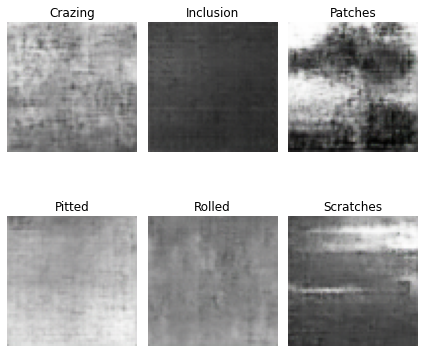

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(6, 6))
cnt = 0
for i in range(2):
    for j in range(3):
        # axs[i, j].imshow(np.reshape(fake.detach().cpu()[cnt, :, ...].numpy(), (config.IMAGE_SIZE,
        #                                                                            config.IMAGE_SIZE, 3)))
        axs[i, j].imshow(np.transpose(fake.detach().cpu()[cnt, :, ...].numpy()))
        axs[i, j].axis('off')
        axs[i, j].set_title(config.LABELS[labels[cnt]])
        cnt += 1
plt.tight_layout()
plt.savefig('Fake_images.png')
plt.show()